<a href="https://colab.research.google.com/github/Kaiziferr/machine_learning/blob/main/imbalanced_classification/01_workshop_imbalanced_multiclass_classification_E_coli.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Contexto**
---

El conjunto de datos describe el problema de clasificar las proteínas de E.coli utilizando sus secuencias de aminoácidos en sus sitios de localización celular. Es decir, predecir cómo se unirá una proteína a una célula en función de la composición química de la proteína antes de que se pliegue.

- Se clasificaron 336 proteínas de E.coli en 8 clases con una precisión del 81 %...




# **Diccionario de datos**
---
- `mcg` : método de McGeoch para el reconocimiento de secuencias de señales
- `gvh` : método de von Heijne para el reconocimiento de secuencias de señales.
- `lip` : puntuación de la secuencia consenso de Signal Peptidase II de von Heijne.
- `chg` : presencia de carga en el extremo N de las lipoproteínas predichas.
- `aac` : puntuación del análisis discriminante del contenido de aminoácidos de la membrana externa y proteínas periplásmicas.
- `alm1`: puntuación del programa de predicción de la región transmembrana de ALOM.
- `alm2`: puntuación del programa ALOM después de excluir de la secuencia las supuestas regiones señal escindibles.
- `class`:
  - cp : citoplasma
  - im : membrana interna sin secuencia señal
  - imS : membrana interna, secuencia de señal escindible
  - imL : lipoproteína de la membrana interna
  - imU : membrana interna, secuencia de señal no escindible
  - om : membrana externa
  - omL : lipoproteína de la membrana externa
  - pp : periplasma







In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import std, mean

from scipy import stats

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.dummy import DummyClassifier

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import f1_score

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# **Data**
---

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/ecoli.csv', header = None)
data

,0,1,2,3,4,5,6,7
0,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
...,...,...,...,...,...,...,...,...
331,0.74,0.56,0.48,0.5,0.47,0.68,0.30,pp
332,0.71,0.57,0.48,0.5,0.48,0.35,0.32,pp
333,0.61,0.60,0.48,0.5,0.44,0.39,0.38,pp
334,0.59,0.61,0.48,0.5,0.42,0.42,0.37,pp


In [3]:
def plot_bars(data, title: str= 'feature', x_size:int=6, y_size:int=5, 
              font_size:int=15):
  fig, ax = plt.subplots(figsize = (x_size, y_size))
  fig.suptitle(f'Count plot {title}', fontsize = font_size)
  sns.countplot(x = data, ax = ax)
  len_data = data.shape[0]

  for p in ax.patches:
    height = int(p.get_height())
    porc = '{0:.2f}%'.format(height/len_data)
    plt.text(p.get_x()+p.get_width()/2., height-height*0.05, porc, ha="center", backgroundcolor='y')

# **Info**
---


In [4]:
data.describe()

,0,1,2,3,4,5,6
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,0.500060,0.500000,0.495476,0.501488,0.500030,0.500179,0.499732
std,0.194634,0.148157,0.088495,0.027277,0.122376,0.215751,0.209411
min,0.000000,0.160000,0.480000,0.500000,0.000000,0.030000,0.000000
25%,0.340000,0.400000,0.480000,0.500000,0.420000,0.330000,0.350000
50%,0.500000,0.470000,0.480000,0.500000,0.495000,0.455000,0.430000
75%,0.662500,0.570000,0.480000,0.500000,0.570000,0.710000,0.710000
max,0.890000,1.000000,1.000000,1.000000,0.880000,1.000000,0.990000


- Se puede observar que los datos fueron normalizados, ya que la media es muy cercana a cero y la desviación cercana a uno.

# **Data split**
---

In [5]:
X = data.iloc[:, :-1]
y = data.iloc[:,-1]

In [6]:
# Encodizar

estimator = LabelEncoder()
y = estimator.fit_transform(y)

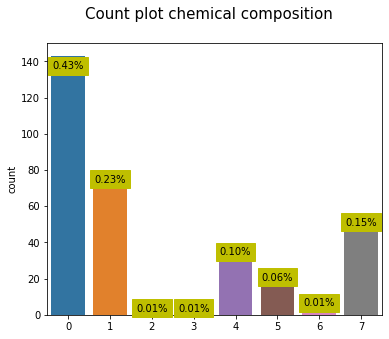

In [7]:
plot_bars(y, 'chemical composition')

- El conjunto de datos sufre un desbalance critico en categorias como imS, imL y omL que tienen alrededor de un 1%

# **Evaluar algoritmos de aprendizaje automático**
---

- Se entrena un modelo dummy con la configuración mas "most_frequent" que predecira la clase mayoritaria.
- Despues se evaluaran distintos modelos no otimizados, osea con hiperparametros por defecto (ya que es solo para el aprendizaje de está practica.)

# **Modelos dummy o base linel**
---


In [8]:
# por motivos de la practica el metodo utiliza como metrica del accuracy,
# la cual no es muy recomendable para aprendizaje desbalanceado.

def evaluate_model(X, y, model):
  # Procedure
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1234)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring="accuracy", cv=cv, n_jobs=1)
  return scores

In [9]:
# Definimos el modelo base, para obtener la linea base
model_dummy = DummyClassifier(strategy='most_frequent')

In [10]:
score = evaluate_model(X, y, model_dummy)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


In [11]:
print('Mean Accuracy: %.3f (%.3f)' % (mean(score), std(score)))

Mean Accuracy: 0.426 (0.007)


In [12]:
print('''
Se aplico la validación cruzada estratificada repetida y se aprecia la media 
y la desviación estandar alrededor de la precisión de clasificación del 
''')
print('Mean Accuracy: %.3f (%.3f) respectivamente' % (mean(score), std(score)))


Se aplico la validación cruzada estratificada repetida y se aprecia la media 
y la desviación estandar alrededor de la precisión de clasificación del 

Mean Accuracy: 0.426 (0.007) respectivamente


In [13]:
np.unique(data[7], return_counts=True)

(array(['cp', 'im', 'imL', 'imS', 'imU', 'om', 'omL', 'pp'], dtype=object),
 array([143,  77,   2,   2,  35,  20,   5,  52]))

Para no perder la información de la categoria 2, 3 y 6 que tiene 2, 2 y 5 registros, se agruparan en una categoria nueva.

In [14]:
data[7].replace(['imS', 'imL', 'omL', 'om'], 'other', inplace=True)

In [15]:
np.unique(data[7], return_counts=True)

(array(['cp', 'im', 'imU', 'other', 'pp'], dtype=object),
 array([143,  77,  35,  29,  52]))

- Se ejecuta nuevamente el modelo dummy para obtener la linea base

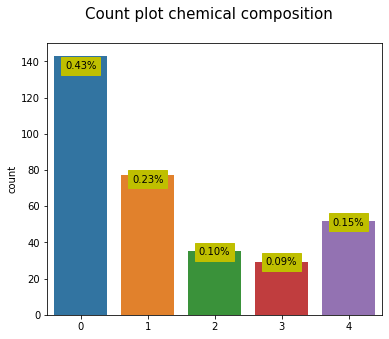

In [16]:
X = data.iloc[:, :-1]
y = data.iloc[:,-1]


estimator = LabelEncoder()
y = estimator.fit_transform(y)

plot_bars(y, 'chemical composition')

In [17]:
score = evaluate_model(X, y, model_dummy)

In [18]:
print('''
Se aplico la validación cruzada estratificada repetida y se aprecia la media 
y la desviación estandar alrededor de la precisión de clasificación del 
''')
print('Mean Accuracy: %.3f (%.3f) respectivamente' % (mean(score), std(score)))


Se aplico la validación cruzada estratificada repetida y se aprecia la media 
y la desviación estandar alrededor de la precisión de clasificación del 

Mean Accuracy: 0.426 (0.007) respectivamente


# **Evaluar modelo**

- Análisis Discriminante Lineal (LDA)
- Máquina de vectores de soporte (SVM)
- Árboles de decisión empaquetados (BAG)
- Bosque aleatorio (RF)
- Extra Trees (ET)


In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier

In [20]:
def get_models():
  models, names = [], []

  models.append(LinearDiscriminantAnalysis())
  names.append('LDA')
  models.append(LogisticRegression(solver='lbfgs', multi_class='multinomial'))
  names.append('LR')
  models.append(KNeighborsClassifier(n_neighbors=3))
  names.append('KNN')
  models.append(GaussianProcessClassifier())
  names.append('GP')
  models.append(LinearSVC())
  names.append('SVM')
  models.append(BaggingClassifier(n_estimators=1000))
  names.append('BAG')
  models.append(RandomForestClassifier(n_estimators=1000))
  names.append('RF')
  models.append(ExtraTreesClassifier(n_estimators=1000))
  names.append('ET')

  return models, names

models, names = get_models()
result = []

for i in range(len(models)):
  score = evaluate_model(X, y, models[i])
  result.append(score)
  print('>%s %.3f (%.3f)' % (names[i], mean(score), std(score)))

>LDA 0.873 (0.012)
>LR 0.832 (0.038)
>KNN 0.849 (0.032)
>GP 0.784 (0.033)
>SVM 0.868 (0.028)
>BAG 0.849 (0.034)
>RF 0.874 (0.023)
>ET 0.861 (0.020)


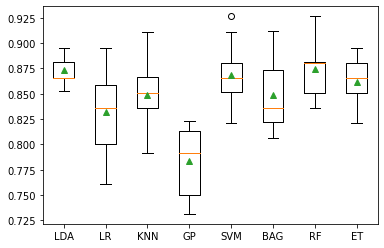

In [21]:
plt.boxplot(result, labels=names, showmeans=True)
plt.show()

Todos los algoritmos tienen un rendimiento tienen un rendimiento superior a la linea base del modelo dummy. Pero la validación cruzada se evaluo con el accuracy, por lo tanto el rendimiento puede no ser confiable.

La media y la mediana están cerca en la grafica, lo que sugiere que los modelos son estables.

LDA tiene la mayor media y la desviación mas pequeña, por lo tanto es el modelo que mejor se desempeña. Los modelo RF, ET, SVM, BAg, el resto de modelos

In [22]:
print('SMOTE sintetizará nuevos ejemplos utilizando k-vecinos más cercanos en el conjunto de datos de entrenamiento, donde, de forma predeterminada, k se establece en 5.')

SMOTE sintetizará nuevos ejemplos utilizando k-vecinos más cercanos en el conjunto de datos de entrenamiento, donde, de forma predeterminada, k se establece en 5.


In [23]:
models, names = get_models()
result = []

for i in range(len(models)):
  steps = [('o', SMOTE(k_neighbors=5)), ('m', models[i])]
  pipeline = Pipeline(steps=steps)
  score = evaluate_model(X, y, pipeline)
  result.append(score)
  print('>%s %.3f (%.3f)' % (names[i], mean(score), std(score)))

>LDA 0.869 (0.026)
>LR 0.868 (0.025)
>KNN 0.813 (0.041)
>GP 0.870 (0.020)
>SVM 0.872 (0.024)
>BAG 0.828 (0.032)
>RF 0.860 (0.028)
>ET 0.863 (0.025)


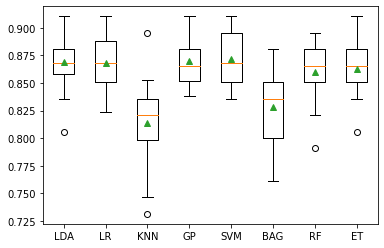

In [24]:
plt.boxplot(result, labels=names, showmeans=True)
plt.show()

- El algoritmo LDA redujo minimamente su rendimiento
- El modelo SVM mejora su rendimiento.
- el modelo gaussiano mejoro su habilidad
